## WorkFlow
1. Combine dataset
2. Feature Engineering
3. Model Building

<ul>
    <b>I. Data Preprocessing</b>
    <li>a. Dataframe</li>
    <li>b. Feature Engineering</li>
</ul>

<ul>
    <b>II. Supervised Learning</b>
    <li>a. Using User Activities data Upsampling</li>
    <li>b. Using User Activities data Downsampling</li>
    <li>c. Using Review Text data Downsampling</li>
    <li>d. AUC-ROC Comparison</li>
    <li>e. Hyperparameter Optimization With Grid Search</li>
    <li>f. Best Model Feature Importance</li>
</ul>

<ul>
    <b>III. Unsupervised Learning</b>
    <li>a. Using all User Activities data</li>
    <li>b. Using Review Text Word2Vec data</li>
</ul>

**Metric**
<li>False Positive: The model predict it's a real review while it's fake</li>
<li>False Negative: The model predict it's a fake review while it's real</li>

We don’t want false positives to be high because fake reviews can damage Yelp’s brand. As consumer trust continues to decline, the churn rate might increase. However, if false negative is high, it can lead to poor user experience, leading to a low user retention rate. As a result, we would use AUC-ROC as the classification model comparison metric because it can determine a prediction model’s performance. Since it’s hard to compute an AUC-ROC score from a confusion matrix, we would use specificity scores to compare both unsupervised and supervised models.

## I. Data Preprocessing

In [14]:
import nltk
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="darkgrid")


import re
import json
import numpy as np
from random import shuffle
from sklearn.svm import SVC
from sklearn import neighbors
from nltk.tokenize import sent_tokenize
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split


from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score

from sklearn.metrics import accuracy_score, recall_score,classification_report 

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN

Using TensorFlow backend.


In [97]:
metadata = pd.read_csv('metadata',sep='\t',header=None)
# user_id, prod_id, rating, label, date
#add column name
metadata.columns =['user_id', 'prod_id', 'rating', 'label','date'] 

In [98]:
reviewContent = pd.read_csv('reviewContent',sep='\t',header=None)
reviewContent.columns=['user_id', 'prod_id','date','review']

### Step 1: DataFrame

In [99]:
#merge reviewContent and metadata together
data=pd.merge(reviewContent,metadata,on=['user_id', 'prod_id','date'])

In [7]:
# check the data description
# no missing values. Good news!
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 608458 entries, 0 to 608457
Data columns (total 6 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   user_id  608458 non-null  int64  
 1   prod_id  608458 non-null  int64  
 2   date     608458 non-null  object 
 3   review   608458 non-null  object 
 4   rating   608458 non-null  float64
 5   label    608458 non-null  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 32.5+ MB


In [100]:
#change date to date time
data['date'] = pd.to_datetime(data['date'])

In [101]:
# number of unique users
data['user_id'].nunique()

260239

In [102]:
# number of unique product id
data['prod_id'].nunique()

5044

In [103]:
data['label'].value_counts()
#1 is ham and -1 is scam

 1    528019
-1     80439
Name: label, dtype: int64

In [1]:
# only 13% of the data belongs to -1 class
80439/(528019+80439)

0.13220140091838714

### Step 2: Feature Engineering

**Part I: Reviewer-centric features**
1. Maximum number of reviews in a day (1)
2. Percentage of reviews with positive / negative ratings (2)
3. Average review length (1)
4. Standard deviation of ratings of the reviewer’s reviews (1)

In [11]:
data.head()

,user_id,prod_id,date,review,rating,label
0,5044,0,2014-11-16,"Drinks were bad, the hot chocolate was watered...",1.0,-1
1,5045,0,2014-09-08,This was the worst experience I've ever had a ...,1.0,-1
2,5046,0,2013-10-06,This is located on the site of the old Spruce ...,3.0,-1
3,5047,0,2014-11-30,I enjoyed coffee and breakfast twice at Toast ...,5.0,-1
4,5048,0,2014-08-28,I love Toast! The food choices are fantastic -...,5.0,-1


In [84]:
#1. Maximum number of reviews in a day
review_day=data.groupby(['user_id','date']).count().sort_values(by='review').reset_index()

In [85]:
max_review=review_day.groupby('user_id').max().reset_index()[['user_id','review']]
max_review.rename(columns={'review':'max_review_on_a_day'},inplace=True)

#merge max_review with data
data=pd.merge(data,max_review,on=['user_id'])

In [14]:
#2. Percentage of reviews with positive / negative ratings (2)

#Assuming positive rating is rating >4 and negative rating is rating <4

In [15]:
(data.groupby(data['rating']
    .apply(lambda x: 'negative' if x < 3 else 'positive' if x > 3 else 'neutral'))['rating']
    .count())

rating
negative     78577
neutral      83117
positive    446764
Name: rating, dtype: int64

In [86]:
# count number of reviews each user_id had written
d=data.groupby('user_id').count().reset_index()[['user_id','review']]
d.rename(columns={'review':'review_count'},inplace=True)

#merge review_count with data
data=pd.merge(data,d,on=['user_id'])
data.head()

,user_id,prod_id,date,review,rating,label,max_review_on_a_day,review_count
0,5044,0,2014-11-16,"Drinks were bad, the hot chocolate was watered...",1.0,-1,1,1
1,5045,0,2014-09-08,This was the worst experience I've ever had a ...,1.0,-1,1,1
2,5046,0,2013-10-06,This is located on the site of the old Spruce ...,3.0,-1,1,4
3,5046,376,2013-11-02,I am becoming frustrated with yelp. I placed ...,3.0,-1,1,4
4,5046,716,2013-10-02,The pumpkin pancakes are quite good but the pl...,3.0,-1,1,4


In [87]:
# if a rating is less than 3 then label it negative, if greater than 3 then label it positive
# else neutral
data['rating_cat']=data['rating'].apply(lambda x:'negative' if x < 3 else 'positive' if x > 3 else 'neutral')

In [18]:
data.head()

,user_id,prod_id,date,review,rating,label,max_review_on_a_day,review_count,rating_cat
0,5044,0,2014-11-16,"Drinks were bad, the hot chocolate was watered...",1.0,-1,1,1,negative
1,5045,0,2014-09-08,This was the worst experience I've ever had a ...,1.0,-1,1,1,negative
2,5046,0,2013-10-06,This is located on the site of the old Spruce ...,3.0,-1,1,4,neutral
3,5046,376,2013-11-02,I am becoming frustrated with yelp. I placed ...,3.0,-1,1,4,neutral
4,5046,716,2013-10-02,The pumpkin pancakes are quite good but the pl...,3.0,-1,1,4,neutral


In [19]:
data.rating.value_counts()

5.0    229364
4.0    217400
3.0     83117
2.0     42982
1.0     35595
Name: rating, dtype: int64

In [88]:
# count number of negative reviews for each user_id
neg_review_count=data.groupby('user_id')['rating_cat'].apply(lambda x: (x=='negative').sum()).reset_index(name='count')['count'].to_list()
# count number of positive reviews for each user_id
pos_review_count=data.groupby('user_id')['rating_cat'].apply(lambda x: (x=='positive').sum()).reset_index(name='count')['count'].to_list()
# count number of neutral reviews for each user_id
neu_review_count=data.groupby('user_id')['rating_cat'].apply(lambda x: (x=='neutral').sum()).reset_index(name='count')['count'].to_list()

In [89]:
review_df=data.groupby('user_id').count().reset_index()[['user_id','review']]

In [90]:
review_df['neg_review_count']=neg_review_count
review_df['pos_review_count']=pos_review_count
review_df['neu_review_count']=neu_review_count

In [23]:
review_df.head()

,user_id,review,neg_review_count,pos_review_count,neu_review_count
0,5044,1,1,0,0
1,5045,1,1,0,0
2,5046,4,0,1,3
3,5047,1,0,1,0
4,5048,1,0,1,0


In [91]:
review_df['neg_rating_percentage']=review_df['neg_review_count']/review_df['review']
review_df['pos_rating_percentage']=review_df['pos_review_count']/review_df['review']
review_df['neu_rating_percentage']=review_df['neu_review_count']/review_df['review']

In [92]:
review_df.drop(['neg_review_count','pos_review_count',
          'neu_review_count','review'],axis=1,inplace=True)

In [26]:
review_df.head()

,user_id,neg_rating_percentage,pos_rating_percentage,neu_rating_percentage
0,5044,1.0,0.00,0.00
1,5045,1.0,0.00,0.00
2,5046,0.0,0.25,0.75
3,5047,0.0,1.00,0.00
4,5048,0.0,1.00,0.00


In [93]:
# merge review_df
data=pd.merge(data,review_df,on=['user_id'])

In [28]:
data.head()

,user_id,prod_id,date,review,rating,label,max_review_on_a_day,review_count,rating_cat,neg_rating_percentage,pos_rating_percentage,neu_rating_percentage
0,5044,0,2014-11-16,"Drinks were bad, the hot chocolate was watered...",1.0,-1,1,1,negative,1.0,0.00,0.00
1,5045,0,2014-09-08,This was the worst experience I've ever had a ...,1.0,-1,1,1,negative,1.0,0.00,0.00
2,5046,0,2013-10-06,This is located on the site of the old Spruce ...,3.0,-1,1,4,neutral,0.0,0.25,0.75
3,5046,376,2013-11-02,I am becoming frustrated with yelp. I placed ...,3.0,-1,1,4,neutral,0.0,0.25,0.75
4,5046,716,2013-10-02,The pumpkin pancakes are quite good but the pl...,3.0,-1,1,4,neutral,0.0,0.25,0.75


In [94]:
#3. Average review length 
data['review_len']=data['review'].apply(lambda x: len(x))

In [95]:
d=data.groupby('user_id')['review_len'].mean().reset_index()
d.rename(columns={'review_len':'avg_review_len'},inplace=True)
data=pd.merge(data,d,on=['user_id'])
data.head()

,user_id,prod_id,date,review,rating,label,max_review_on_a_day,review_count,rating_cat,neg_rating_percentage,pos_rating_percentage,neu_rating_percentage,review_len,avg_review_len
0,5044,0,2014-11-16,"Drinks were bad, the hot chocolate was watered...",1.0,-1,1,1,negative,1.0,0.00,0.00,187,187.0
1,5045,0,2014-09-08,This was the worst experience I've ever had a ...,1.0,-1,1,1,negative,1.0,0.00,0.00,1375,1375.0
2,5046,0,2013-10-06,This is located on the site of the old Spruce ...,3.0,-1,1,4,neutral,0.0,0.25,0.75,257,245.5
3,5046,376,2013-11-02,I am becoming frustrated with yelp. I placed ...,3.0,-1,1,4,neutral,0.0,0.25,0.75,352,245.5
4,5046,716,2013-10-02,The pumpkin pancakes are quite good but the pl...,3.0,-1,1,4,neutral,0.0,0.25,0.75,154,245.5


In [96]:
#Standard deviation of ratings of the reviewer’s reviews 
d=data.groupby('user_id')['rating'].std().reset_index()
d.rename(columns={'rating':'std_rating'},inplace=True)
data=pd.merge(data,d,on=['user_id'])
data.head()

,user_id,prod_id,date,review,rating,label,max_review_on_a_day,review_count,rating_cat,neg_rating_percentage,pos_rating_percentage,neu_rating_percentage,review_len,avg_review_len,std_rating
0,5044,0,2014-11-16,"Drinks were bad, the hot chocolate was watered...",1.0,-1,1,1,negative,1.0,0.00,0.00,187,187.0,NaN
1,5045,0,2014-09-08,This was the worst experience I've ever had a ...,1.0,-1,1,1,negative,1.0,0.00,0.00,1375,1375.0,NaN
2,5046,0,2013-10-06,This is located on the site of the old Spruce ...,3.0,-1,1,4,neutral,0.0,0.25,0.75,257,245.5,0.5
3,5046,376,2013-11-02,I am becoming frustrated with yelp. I placed ...,3.0,-1,1,4,neutral,0.0,0.25,0.75,352,245.5,0.5
4,5046,716,2013-10-02,The pumpkin pancakes are quite good but the pl...,3.0,-1,1,4,neutral,0.0,0.25,0.75,154,245.5,0.5


In [97]:
data['std_rating'] = data['std_rating'].fillna(0)

In [98]:
data.head()

,user_id,prod_id,date,review,rating,label,max_review_on_a_day,review_count,rating_cat,neg_rating_percentage,pos_rating_percentage,neu_rating_percentage,review_len,avg_review_len,std_rating
0,5044,0,2014-11-16,"Drinks were bad, the hot chocolate was watered...",1.0,-1,1,1,negative,1.0,0.00,0.00,187,187.0,0.0
1,5045,0,2014-09-08,This was the worst experience I've ever had a ...,1.0,-1,1,1,negative,1.0,0.00,0.00,1375,1375.0,0.0
2,5046,0,2013-10-06,This is located on the site of the old Spruce ...,3.0,-1,1,4,neutral,0.0,0.25,0.75,257,245.5,0.5
3,5046,376,2013-11-02,I am becoming frustrated with yelp. I placed ...,3.0,-1,1,4,neutral,0.0,0.25,0.75,352,245.5,0.5
4,5046,716,2013-10-02,The pumpkin pancakes are quite good but the pl...,3.0,-1,1,4,neutral,0.0,0.25,0.75,154,245.5,0.5


In [99]:
#save so far to a pickle
data.to_pickle("./data_partone.pkl")

In [16]:
data = pd.read_pickle("data_partone.pkl")

**Part II: Review-centric features**
1. Structural features (5): average word length, number of sentences,
average sentence length, percentage of numerals, percentage of capitalized words.
2. Semantic features (2): We calculate the percentages of positive and negative opinionbearing words in each review.

In [17]:
def avg_word_length(x):
    sentence = x
    words = sentence.split()
    average = round(sum(len(word) for word in words) / len(words),2)
    return average

In [18]:
data['avg_word_length']=data['review'].apply(lambda x: avg_word_length(x))

In [19]:
def num_sent(x):
    number_of_sentences = sent_tokenize(x)
    return len(number_of_sentences)

In [20]:
data['num_sent']=data['review'].apply(lambda x: num_sent(x))

In [104]:
data['review'][0]

'Drinks were bad, the hot chocolate was watered down and the latte had a burnt taste to it. The food was also poor quality, but the service was the worst part, their cashier was very rude.'

In [21]:
def percentage_of_numerals(x):
    numbers = sum(c.isdigit() for c in x)
    letter = sum(c.isalpha() for c in x)
    
    try: 
        result = numbers / letter
    except ZeroDivisionError:
        result=-1
    return result

In [22]:
data['percentage_of_numerals']=data['review'].apply(lambda x: percentage_of_numerals(x))

In [46]:
data['percentage_of_numerals'].value_counts()

0.000000    353314
0.006944       316
0.007937       308
0.010417       299
0.010000       294
             ...  
0.022680         1
0.030519         1
0.001281         1
0.000705         1
0.016060         1
Name: percentage_of_numerals, Length: 21496, dtype: int64

In [23]:
# if numbers/letter returns ZeroDivisionError
# this means there's 0 letter in the review
data[data['percentage_of_numerals']==-1]

,user_id,prod_id,date,review,rating,label,max_review_on_a_day,review_count,rating_cat,neg_rating_percentage,pos_rating_percentage,neu_rating_percentage,review_len,avg_review_len,std_rating,avg_word_length,num_sent,percentage_of_numerals
4692,5569,7,2013-02-02,-,4.0,1,1,1,positive,0.000000,1.000000,0.000000,1,1.000000,0.000000,1.0,1,-1.0
8788,6151,9,2014-07-07,:),4.0,-1,1,1,positive,0.000000,1.000000,0.000000,2,2.000000,0.000000,2.0,1,-1.0
92145,15900,3745,2013-06-09,.,5.0,1,3,23,positive,0.173913,0.608696,0.217391,1,596.956522,1.233588,1.0,1,-1.0
156194,26230,3212,2014-11-28,.,3.0,1,3,3,neutral,0.000000,0.666667,0.333333,1,13.000000,1.000000,1.0,1,-1.0
156195,26230,4080,2014-11-28,.,4.0,1,3,3,positive,0.000000,0.666667,0.333333,1,13.000000,1.000000,1.0,1,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
593844,250967,4698,2014-07-25,?,3.0,-1,1,1,neutral,0.000000,0.000000,1.000000,1,1.000000,0.000000,1.0,1,-1.0
596978,254021,4735,2013-06-05,! !,4.0,1,1,1,positive,0.000000,1.000000,0.000000,3,3.000000,0.000000,1.0,2,-1.0
603594,260489,4904,2013-10-13,.,4.0,1,1,1,positive,0.000000,1.000000,0.000000,1,1.000000,0.000000,1.0,1,-1.0
604085,260975,4366,2014-08-02,.,5.0,-1,1,1,positive,0.000000,1.000000,0.000000,1,1.000000,0.000000,1.0,1,-1.0


In [24]:
#remove reviews that doesn't contain any words
data=data[data['percentage_of_numerals'] != -1 ]

In [25]:
# percentage of capitalized words
def percentage_of_capitalized(x):
    cap = sum(c.isupper() for c in x)
    letter = sum(c.isalpha() for c in x)
    
    try: 
        result = cap / letter
    except ZeroDivisionError:
        result=-1
    return cap/letter

In [26]:
data['percentage_of_capitalized']=data['review'].apply(lambda x: percentage_of_capitalized(x))

In [27]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [23]:
#clean up the review text
from nltk.tokenize import word_tokenize
import string
import re
from nltk.corpus import stopwords

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    #tokenizer breaks string into a list of words
    text = word_tokenize(text)
    text = " ".join([c for c in text if c not in string.punctuation])
    text = text.lower() # lowercase text
    text = re.compile('"''#&?!:_[/(){}\[\]\|@,;.]').sub(' ', text) # replace symbols by space in text. substitute the matched string with space.
    text = re.sub(r'\d+','', text) # remove symbols and numbers
    text = ' '.join(word for word in text.split() if word not in stopwords.words('english')) # remove stopwors from text
    return text

In [31]:
#save so far to a pickle
# data.to_pickle("./data_parttwo.pkl")

In [191]:
data.label.value_counts()

 1    527966
-1     80425
Name: label, dtype: int64

In [91]:
80425/(527966+80425)

0.1321929482849023

In [12]:
data=data.reset_index()

In [104]:
data.rename(columns={"index": "review_id"},inplace=True)

In [54]:
data.label.value_counts()

 1    527966
-1     80425
Name: label, dtype: int64

In [23]:
data.columns

Index(['review_id', 'user_id', 'prod_id', 'date', 'review', 'rating', 'label',
       'max_review_on_a_day', 'review_count', 'rating_cat',
       'neg_rating_percentage', 'pos_rating_percentage',
       'neu_rating_percentage', 'review_len', 'avg_review_len', 'std_rating',
       'avg_word_length', 'num_sent', 'percentage_of_numerals',
       'percentage_of_capitalized'],
      dtype='object')

In [109]:
data.drop(['user_id', 'prod_id', 'date','rating_cat'],axis=1,inplace=True)

In [110]:
data = data.reindex(columns=['label','review_id', 'review', 'rating',
                                          'max_review_on_a_day',
                                          'review_count', 'neg_rating_percentage',
                                          'pos_rating_percentage', 'neu_rating_percentage', 'review_len',
                                          'avg_review_len', 'std_rating', 'avg_word_length', 'num_sent',
                                          'percentage_of_numerals', 'percentage_of_capitalized'])

In [111]:
data.head()

,label,review_id,review,rating,max_review_on_a_day,review_count,neg_rating_percentage,pos_rating_percentage,neu_rating_percentage,review_len,avg_review_len,std_rating,avg_word_length,num_sent,percentage_of_numerals,percentage_of_capitalized
0,-1,0,"Drinks were bad, the hot chocolate was watered...",1.0,1,1,1.0,0.00,0.00,187,187.0,0.0,4.22,2,0.00000,0.013605
1,-1,1,This was the worst experience I've ever had a ...,1.0,1,1,1.0,0.00,0.00,1375,1375.0,0.0,4.50,16,0.00565,0.022599
2,-1,2,This is located on the site of the old Spruce ...,3.0,1,4,0.0,0.25,0.75,257,245.5,0.5,4.10,4,0.00000,0.055276
3,-1,3,I am becoming frustrated with yelp. I placed ...,3.0,1,4,0.0,0.25,0.75,352,245.5,0.5,4.63,5,0.00722,0.036101
4,-1,4,The pumpkin pancakes are quite good but the pl...,3.0,1,4,0.0,0.25,0.75,154,245.5,0.5,4.70,2,0.00000,0.024194


In [112]:
data.to_csv('full_activities_review.csv',index=False)

## II. Supervised Learning

#### Deal with Imbalanced Data

For example, say you have a dataset in which 92% of the data is labelled as ‘Not Fraud’ and the remaining 8% are cases of ‘Fraud’. The data is clearly imbalanced. Now say our model ends up as classifying everything it sees as ‘Not Fraud’. If we look at the accuracy, however, it’s a magnificent 92%. But the bank still cares about those ‘Fraud’ cases

#### 1. Up-sample Minority Class

Over sampling: This method uses synthetic data generation to increase the number of samples in the data set. 
SMOTE: What smote does is simple. First it finds the n-nearest neighbors in the minority class for each of the samples in the class . Then it draws a line between the the neighbors an generates random points on the lines.

ADASYN: similar to SMOTE, but only create synthetic data in the boundary where the it's hard to define.

#### 2. Down-sample Majority Class

Under sampling: In this method basically we downsize the actual data set in such a way that the ratio of the dependent categories become 10:1. This method is not recommended since we are actually reducing the data set thus giving the model less data to feed on. 

### Part I: User Activities Data

In [17]:
def make_pipeline():
    "Create a single pipeline that processing the data and then fits the classification."  
    
    rf = RandomForestClassifier(random_state=50)
    gb=GradientBoostingClassifier(random_state=50)
    lr = LogisticRegression(random_state=50)
    classifiers=[rf,gb,lr]

    pipeline = []
    for classifier in classifiers:
        pipe = Pipeline(steps=[('classifier', classifier)])
        pipeline.append(pipe)

    return pipeline

In [18]:
def sort_models(pipelines, X_data, y_data):
    """Sort models based on their f1 score."""
    scores = []
    for pipe in pipelines:
        y_pred = pipe.predict(X_data)
        f1score = f1_score(y_data, y_pred, average='weighted')
        recallscore=recall_score(y_data,y_pred)
        accuracyscore=accuracy_score(y_data,y_pred)

        aucscore=roc_auc_score(y_data, pipe.predict_proba(X_data)[:,1])
        
        classfier_name = pipe.steps[-1][1].__class__.__name__.split('.')[-1]
        scores.append([classfier_name,f1score,recallscore,accuracyscore,aucscore])
        
    scores_sorted = sorted(scores,key=lambda x:x[1],reverse=True)
    
    return scores_sorted

In [24]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1]) #TP/TP+FP
#             How much were correctly classified as positive out of all positives.
            recall    = cf[1,1] / sum(cf[1,:]) #TP/TP+FN
            specificity = cf[0,0] / sum(cf[0,:]) #TN/TN+FP 
            f1_score  = 2*(precision*recall / (precision + recall))
        
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nSpecificity={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,specificity,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)


### a. User Activities Data Upsampling

In [44]:
X_up=data.iloc[:,3:]
y_up = data['label']

In [45]:
X_up_train, X_up_test, y_up_train, y_up_test = train_test_split(X_up, y_up, random_state=3)

X_smoted_train, y_smoted_train = SMOTE(random_state=42).fit_sample(X_up_train, y_up_train)
X_adasyn_train, y_adasyn_train = ADASYN(random_state=42).fit_sample(X_up_train, y_up_train)

In [46]:
smote_pipelines = make_pipeline()
# Train all the models
for pipe in smote_pipelines:
    pipe.fit(X_smoted_train, y_smoted_train)

/Users/kessiezhang/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/kessiezhang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [47]:
# apply sort_models function from above
smoted_sorted_model = sort_models(smote_pipelines, X_up_test, y_up_test)
smoted_sort_model_df = pd.DataFrame(smoted_sorted_model)
smoted_sort_model_df.columns = ['Model','F1 Score','Recall Score','Accuracy Score','AUC Score']
smoted_sort_model_df = pd.melt(smoted_sort_model_df,id_vars=['Model'])

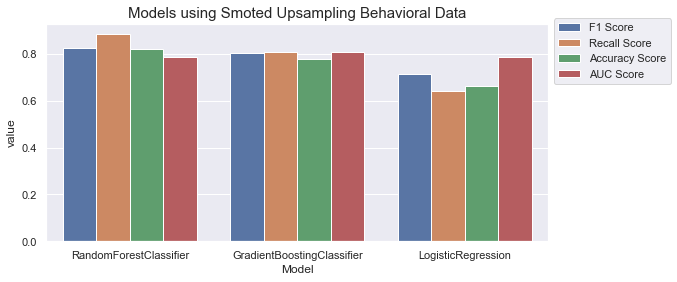

In [48]:
plt.figure(figsize=(9, 4))
plt.title('Models using Smoted Upsampling Behavioral Data',fontsize=15)
ax = sns.barplot(x="Model", y="value", hue = "variable",data=smoted_sort_model_df)
ax.legend(bbox_to_anchor=(1.0, 1.05));

In [49]:
smoted_sort_model_df

,Model,variable,value
0,RandomForestClassifier,F1 Score,0.826650
1,GradientBoostingClassifier,F1 Score,0.804251
2,LogisticRegression,F1 Score,0.716710
3,RandomForestClassifier,Recall Score,0.884866
4,GradientBoostingClassifier,Recall Score,0.807189
5,LogisticRegression,Recall Score,0.640230
6,RandomForestClassifier,Accuracy Score,0.821299
7,GradientBoostingClassifier,Accuracy Score,0.779142
8,LogisticRegression,Accuracy Score,0.662961
9,RandomForestClassifier,AUC Score,0.788917


In [50]:
# best smote model performanxce -- gradientboosting
y_pred_smoted=smote_pipelines[1].predict(X_up_test)

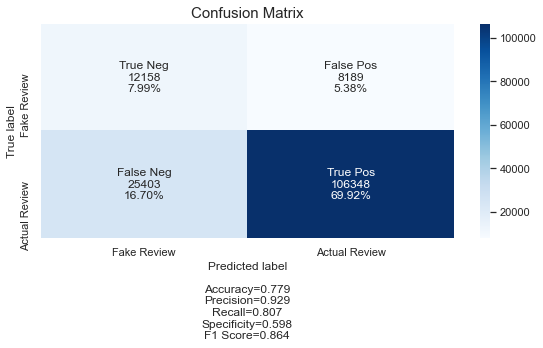

In [51]:
cm_smoted = confusion_matrix(y_up_test,y_pred_smoted )

sns.set(font_scale=1.0)
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Fake Review', 'Actual Review']
make_confusion_matrix(cm_smoted, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues',figsize=(8,5))

plt.title('Confusion Matrix',fontsize=15)
plt.tight_layout();

In [52]:
adasyn_pipelines = make_pipeline()
# Train all the models
for pipe in adasyn_pipelines:
    pipe.fit(X_adasyn_train, y_adasyn_train)

/Users/kessiezhang/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/kessiezhang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [53]:
# apply sort_models function from above
adasyn_sorted_model = sort_models(adasyn_pipelines, X_up_test, y_up_test)
adasyn_sort_model_df = pd.DataFrame(adasyn_sorted_model)
adasyn_sort_model_df.columns = ['Model','F1 Score','Recall Score','Accuracy Score','AUC Score']
adasyn_sort_model_df = pd.melt(adasyn_sort_model_df,id_vars=['Model'])

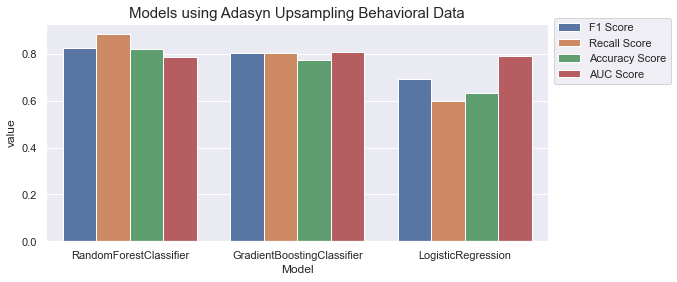

In [54]:
plt.figure(figsize=(9, 4))
ax = sns.barplot(x="Model", y="value", hue = "variable",data=adasyn_sort_model_df)
ax.legend(bbox_to_anchor=(1.0, 1.05))
plt.title('Models using Adasyn Upsampling Behavioral Data',fontsize=15);

In [55]:
adasyn_sort_model_df

,Model,variable,value
0,RandomForestClassifier,F1 Score,0.826566
1,GradientBoostingClassifier,F1 Score,0.802366
2,LogisticRegression,F1 Score,0.692168
3,RandomForestClassifier,Recall Score,0.884684
4,GradientBoostingClassifier,Recall Score,0.802704
5,LogisticRegression,Recall Score,0.601028
6,RandomForestClassifier,Accuracy Score,0.821168
7,GradientBoostingClassifier,Accuracy Score,0.776296
8,LogisticRegression,Accuracy Score,0.634071
9,RandomForestClassifier,AUC Score,0.787482


In [56]:
# best adasyn model performanxce -- gradientboosting
y_pred_adasyn=adasyn_pipelines[1].predict(X_up_test)

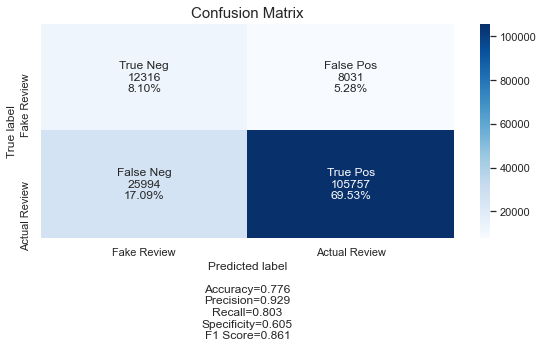

In [57]:
# best adasyn model performanxce
cm_adasyn = confusion_matrix(y_up_test, y_pred_adasyn)

# sns.set(font_scale=1.0)
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Fake Review', 'Actual Review']
make_confusion_matrix(cm_adasyn, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues',figsize=(8,5))

plt.title('Confusion Matrix',fontsize=15)
plt.tight_layout();

### b. User Activities Data Downsampling

In [58]:
# Separate majority and minority classes
df_majority = data[data.label==1]
df_minority = data[data.label==-1]

In [59]:
from sklearn.utils import resample
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=80425,     # to match minority class
                                 random_state=123) # reproducible results
 
# Combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])
 
# Display new class counts
df_downsampled.label.value_counts()

-1    80425
 1    80425
Name: label, dtype: int64

In [8]:
# df_downsampled.to_csv('df_downsampled.csv',index=False)
# df_downsampled=pd.read_csv('df_downsampled.csv')

### Build W2V and Merge with User Activities Data Downsampling

Doing so can make sure that the data we use to train text classification and user activities classification models are the same. Text classification will use the review's word2vec form while user activities classification will use the reviewer's user activities.

In [9]:
# clean the data
import string
from nltk.tokenize import RegexpTokenizer
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [10]:
def remove_punctuation(text):
    #tokenizer breaks string into a list of words
    tokenizer = RegexpTokenizer(r'\w+')
    text = tokenizer.tokenize(text)
    text = " ".join([c for c in text if c not in string.punctuation])
    return text

In [9]:
text_df_downsampled=df_downsampled.iloc[:,:3]

In [10]:
text_df_downsampled.head()

,label,review_id,review
0,1,558391,"Damn good pizzaria. Old fashioned, brick oven ..."
1,1,93260,"The entrees here are classic hearty dishes, th..."
2,1,328802,What can I say? If you want better Italian foo...
3,1,138491,Stopped by here for lunch and a brew on a warm...
4,1,555771,We need one of these in every neighborhood. Su...


In [6]:
# text_df_downsampled.to_csv('text_df_downsampled.csv',index=False)
# text_df_downsampled=pd.read_csv('text_df_downsampled.csv')

In [11]:
# we only build w2v on downsample data because it will take too long to 
# convert text data to a vector if the data is big
text_df_downsampled.review=text_df_downsampled.review.apply(lambda x: remove_punctuation(x))

In [12]:
text_df_downsampled.head()

,label,review_id,review
0,1,558391,Damn good pizzaria Old fashioned brick oven co...
1,1,93260,The entrees here are classic hearty dishes thi...
2,1,328802,What can I say If you want better Italian food...
3,1,138491,Stopped by here for lunch and a brew on a warm...
4,1,555771,We need one of these in every neighborhood Sup...


In [14]:
text_df_downsampled.to_csv('clean_text_df_downsampled.csv',index=False)

In [15]:
file_path = 'clean_text_df_downsampled.csv'

In [16]:
import h2o.model.clustering
from h2o.model.clustering import H2OClusteringModel
from nltk.corpus import stopwords

In [17]:
import h2o
h2o.init(ip="localhost", port=54323)
from h2o.estimators.word2vec import H2OWord2vecEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator

Checking whether there is an H2O instance running at http://localhost:54323 ..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_221"; Java(TM) SE Runtime Environment (build 1.8.0_221-b11); Java HotSpot(TM) 64-Bit Server VM (build 25.221-b11, mixed mode)
  Starting server from /Users/kessiezhang/anaconda3/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/b6/hjxvyjq977ndl2kzn72hgh2c0000gn/T/tmpq9e7xbcb
  JVM stdout: /var/folders/b6/hjxvyjq977ndl2kzn72hgh2c0000gn/T/tmpq9e7xbcb/h2o_kessiezhang_started_from_python.out
  JVM stderr: /var/folders/b6/hjxvyjq977ndl2kzn72hgh2c0000gn/T/tmpq9e7xbcb/h2o_kessiezhang_started_from_python.err
  Server is running at http://127.0.0.1:54323
Connecting to H2O server at http://127.0.0.1:54323 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,America/Los_Angeles
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.0.6
H2O_cluster_version_age:,2 months and 28 days
H2O_cluster_name:,H2O_from_python_kessiezhang_b6jgeb
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.778 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


In [18]:
text_log =(h2o.import_file(file_path, destination_frame = "review",
                          col_names = ["label","review_id","review"], 
                          col_types = ["int","int","string"]))

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [19]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kessiezhang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [20]:
STOP_WORDS = set(stopwords.words('english'))

In [21]:
def tokenize(sentences, stop_word = STOP_WORDS):
    tokenized = sentences.tokenize("\\W+")
    tokenized_lower = tokenized.tolower()
    tokenized_filtered = tokenized_lower[(tokenized_lower.nchar() >= 2) | (tokenized_lower.isna()),:]
    tokenized_words = tokenized_filtered[tokenized_filtered.grep("[0-9]",invert=True,output_logical=True),:]
    tokenized_words = tokenized_words[(tokenized_words.isna()) | (~ tokenized_words.isin(STOP_WORDS)),:]
    return tokenized_words

In [22]:
def predict(review_text_test,w2v,gbm):
    words = tokenize(h2o.H2OFrame(review_text_test).ascharacter())
    job_title_vec = w2v.transform(words, aggregate_method="AVERAGE")
    return(gbm.predict(test_data=job_title_vec))

In [23]:
print("Break chat text into sequence of words")
words = tokenize(text_log["review"])


Break chat text into sequence of words


In [24]:
print("Build word2vec model")
# min_word_freq default is 5, thats why I have missing values
w2v_model = H2OWord2vecEstimator(sent_sample_rate = 0.0, epochs = 5)
new_w2v_model = w2v_model.train(training_frame=words)
w2v_model.train(training_frame=words)

Build word2vec model
word2vec Model Build progress: |██████████████████████████████████████████| 100%
word2vec Model Build progress: |██████████████████████████████████████████| 100%


In [25]:
print("Calculate a vector for each review text")
review_text_vecs = w2v_model.transform(words, aggregate_method = "AVERAGE")

Calculate a vector for each review text


In [26]:
print("Prepare training&validation data (keep only review texts made of known words)")
valid_chat_text= ~ review_text_vecs["C1"].isna()
data = text_log[valid_chat_text,:].cbind(review_text_vecs[valid_chat_text,:])

Prepare training&validation data (keep only review texts made of known words)


In [27]:
data_as_df_5 = h2o.as_list(data)

In [28]:
# data_as_df_5.to_csv('clean_data_as_df.csv')

In [37]:
df_downsampled.drop(['label','review'],axis=1,inplace=True)

In [39]:
#merge w2v with df_downsampled data

downsample_final_df=pd.merge(data_as_df_5,df_downsampled, left_on=['review_id'], right_on=['review_id'])
downsample_final_df.shape

(160802, 117)

In [40]:
upsample_final_df.head(1)

,label,review_id,review,C1,C2,C3,C4,C5,C6,C7,...,neg_rating_percentage,pos_rating_percentage,neu_rating_percentage,review_len,avg_review_len,std_rating,avg_word_length,num_sent,percentage_of_numerals,percentage_of_capitalized
0,1,558391,Damn good pizzaria Old fashioned brick oven co...,0.118176,-0.00554,-0.118697,0.004663,0.225756,0.110888,-0.067641,...,0.0,1.0,0.0,700,700.0,0.0,4.7,8,0.0,0.019469


In [41]:
downsample_final_df.drop(['review_id','rating_cat'],axis=1,inplace=True)

In [63]:
# downsample_final_df.to_csv('downsample_final_df.csv',index=False)

In [60]:
downsample_final_df=pd.read_csv('downsample_final_df.csv')

In [61]:
X=downsample_final_df.iloc[:,1:]
y = downsample_final_df['label']
X.shape, y.shape

((160802, 114), (160802,))

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [63]:
#user activities
X_activity_train=X_train.iloc[:,101:]
X_activity_test=X_test.iloc[:,101:]

In [64]:
activity_pipelines = make_pipeline()
# Train all the models
for pipe in activity_pipelines:
    pipe.fit(X_activity_train, y_train)

/Users/kessiezhang/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/kessiezhang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [65]:
activity_sorted_model = sort_models(activity_pipelines, X_activity_test, y_test)
activity_sorted_model_df = pd.DataFrame(activity_sorted_model)
activity_sorted_model_df.columns = ['Model','F1 Score','Recall Score','Accuracy Score','AUC Score']
activity_sorted_model_df = pd.melt(activity_sorted_model_df,id_vars=['Model'])

In [66]:
activity_sorted_model_df

,Model,variable,value
0,GradientBoostingClassifier,F1 Score,0.752331
1,RandomForestClassifier,F1 Score,0.746471
2,LogisticRegression,F1 Score,0.722182
3,GradientBoostingClassifier,Recall Score,0.664920
4,RandomForestClassifier,Recall Score,0.661160
5,LogisticRegression,Recall Score,0.635764
6,GradientBoostingClassifier,Accuracy Score,0.754236
7,RandomForestClassifier,Accuracy Score,0.748329
8,LogisticRegression,Accuracy Score,0.724293
9,GradientBoostingClassifier,AUC Score,0.824268


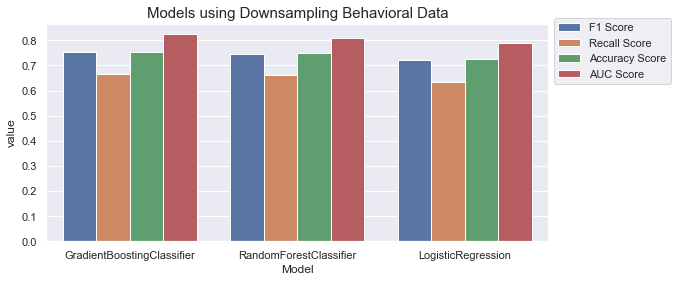

In [67]:
plt.figure(figsize=(9, 4))
ax = sns.barplot(x="Model", y="value", hue = "variable",data=activity_sorted_model_df)
ax.legend(bbox_to_anchor=(1.0, 1.05))
plt.title('Models using Downsampling Behavioral Data',fontsize=15);

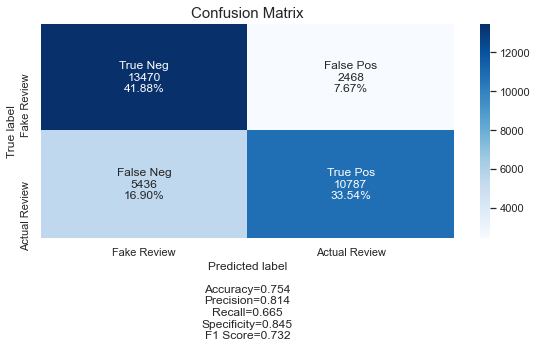

In [68]:
# the best model is gb
# pipelines=[rf,gb,lr]
cm_activity = confusion_matrix(y_test, activity_pipelines[1].predict(X_activity_test))

sns.set(font_scale=1.0)
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Fake Review', 'Actual Review']
make_confusion_matrix(cm_activity, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues',figsize=(8,5))

plt.title('Confusion Matrix',fontsize=15)
plt.tight_layout();

### c. Text Data Downsampling

In [69]:
#text 
X_text_train=X_train.iloc[:,1:101]
X_text_test=X_test.iloc[:,1:101]

In [70]:
text_pipelines = make_pipeline()
# Train all the models
for pipe in text_pipelines:
    pipe.fit(X_text_train, y_train)

/Users/kessiezhang/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/kessiezhang/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [71]:
text_sorted_model = sort_models(text_pipelines, X_text_test, y_test)
text_sorted_model_df = pd.DataFrame(text_sorted_model)
text_sorted_model_df.columns = ['Model','F1 Score','Recall Score','Accuracy Score','AUC Score']
text_sorted_model_df = pd.melt(text_sorted_model_df,id_vars=['Model'])

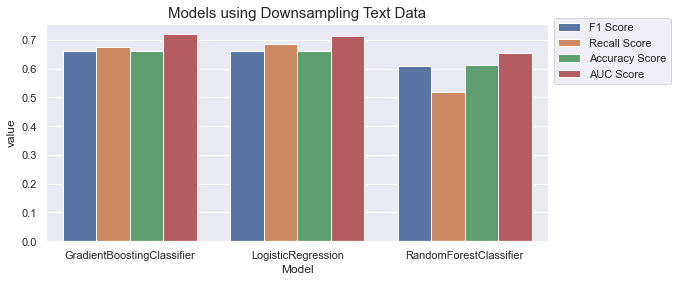

In [72]:
plt.figure(figsize=(9, 4))
ax = sns.barplot(x="Model", y="value", hue = "variable",data=text_sorted_model_df)
ax.legend(bbox_to_anchor=(1.0, 1.05))
plt.title('Models using Downsampling Text Data',fontsize=15);

In [75]:
text_sorted_model_df

,Model,variable,value
0,GradientBoostingClassifier,F1 Score,0.662773
1,LogisticRegression,F1 Score,0.660571
2,RandomForestClassifier,F1 Score,0.608964
3,GradientBoostingClassifier,Recall Score,0.674043
4,LogisticRegression,Recall Score,0.685508
5,RandomForestClassifier,Recall Score,0.519694
6,GradientBoostingClassifier,Accuracy Score,0.662821
7,LogisticRegression,Accuracy Score,0.660800
8,RandomForestClassifier,Accuracy Score,0.612294
9,GradientBoostingClassifier,AUC Score,0.719623


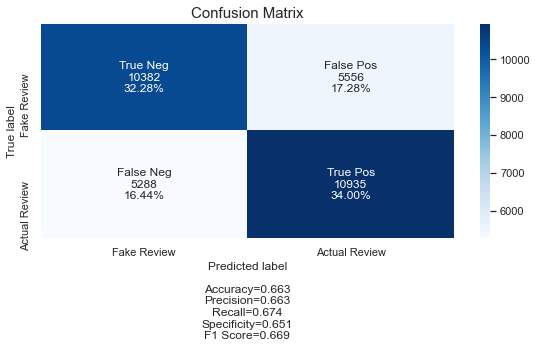

In [76]:
# the best model is gb
cm_text = confusion_matrix(y_test, text_pipelines[1].predict(X_text_test))

sns.set(font_scale=1.0)
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Fake Review', 'Actual Review']
make_confusion_matrix(cm_text, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues',figsize=(8,5))

plt.title('Confusion Matrix',fontsize=15)
plt.tight_layout();

### d. AUC-ROC Comparison

In [74]:
from sklearn.metrics import roc_curve

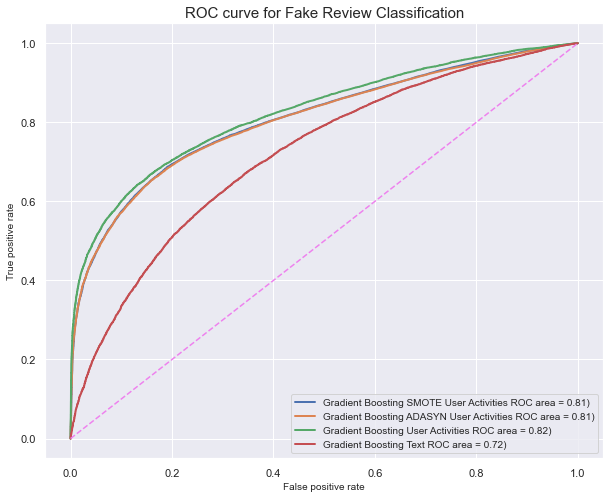

In [77]:
plt.figure(figsize=(10,8))

y_pred_smoted=smote_pipelines[0].predict(X_up_test)

#GradientBoosting Upsampling
fpr_gb1, tpr_gb1, thresholds = roc_curve(y_up_test, smote_pipelines[1].predict_proba(X_up_test)[:,1])
fpr_gb2, tpr_gb2, thresholds = roc_curve(y_up_test, adasyn_pipelines[1].predict_proba(X_up_test)[:,1])
roc_auc_GB_smote=roc_auc_score(y_up_test, smote_pipelines[1].predict_proba(X_up_test)[:,1])
roc_auc_GB_adasyn=roc_auc_score(y_up_test, adasyn_pipelines[1].predict_proba(X_up_test)[:,1])

#GradientBoosting with SMOTE and ADASYN
plt.plot(fpr_gb1, tpr_gb1,lw=2, label='Gradient Boosting SMOTE User Activities ROC area = %0.2f)' % roc_auc_GB_smote)
plt.plot(fpr_gb2, tpr_gb2,lw=2, label='Gradient Boosting ADASYN User Activities ROC area = %0.2f)' % roc_auc_GB_adasyn)

#GradientBoosting with Downsampling 
fpr_gb1, tpr_gb1, thresholds = roc_curve(y_test, activity_pipelines[1].predict_proba(X_activity_test)[:,1])
fpr_gb2, tpr_gb2, thresholds = roc_curve(y_test, text_pipelines[1].predict_proba(X_text_test)[:,1])
roc_auc_GB_activity=roc_auc_score(y_test, activity_pipelines[1].predict_proba(X_activity_test)[:,1])
roc_auc_GB_text=roc_auc_score(y_test, text_pipelines[1].predict_proba(X_text_test)[:,1])

#GradientBoosting with Downsampling
plt.plot(fpr_gb1, tpr_gb1,lw=2, label='Gradient Boosting User Activities ROC area = %0.2f)' % roc_auc_GB_activity)
plt.plot(fpr_gb2, tpr_gb2,lw=2, label='Gradient Boosting Text ROC area = %0.2f)' % roc_auc_GB_text)

plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.legend(loc="lower right",ncol=1,fontsize = 'small')
plt.xlabel('False positive rate',fontsize=10)
plt.ylabel('True positive rate',fontsize=10)
plt.title('ROC curve for Fake Review Classification',fontsize=15);

### e. Best Model Grid Search
From above, we can see that using user activities data give us better results. The best model is GradientBoostingClassifier. What we can here is to use grid search to optimize the model performance.

In [79]:
def make_random_cv(clf):
    """
    Steps:
    1. Define Estimator
    2. Define hyperparameter search space
    3. Instantiate GridSearchCV
    """
    if clf._final_estimator.__class__.__name__ == 'GradientBoostingClassifier':

        
                #parameters to tune
        hyperparameters = {
#          'classifier__learning_rate': [0.01,0.05,0.1,0.5,1],
         'classifier__max_depth' : [5,7,9],
         'classifier__min_samples_split': list(range(2, 6))
#          'classifier__min_samples_leaf': list(range(1, 6)),
#          'classifier__max_features': list(range(1, 10))
        }

        clf_random_cv = GridSearchCV(clf,
                                     hyperparameters,
                                     cv=5,
                                     #optimize roc curve
                                     scoring='roc_auc',
                                     refit=True,
                                     n_jobs=-1)

    return clf_random_cv

gb = make_random_cv(activity_pipelines[1])
gb_model = gb.fit(X_activity_train, y_train)
print(gb_model.best_estimator_._final_estimator)

# use the best estimator to train the model
new_gb_model =gb_model.best_estimator_._final_estimator.fit(X_activity_test,y_test)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=9,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=50, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)


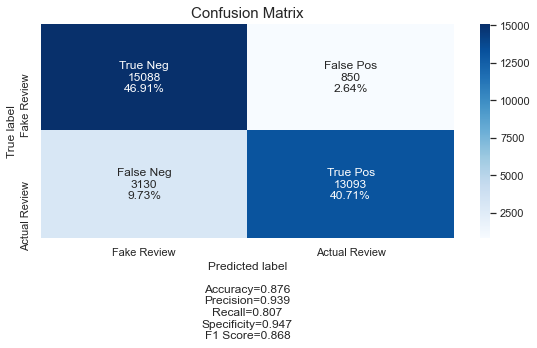

In [80]:
cm_best_activity = confusion_matrix(y_test, new_gb_model.predict(X_activity_test))

sns.set(font_scale=1.0)
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Fake Review', 'Actual Review']
make_confusion_matrix(cm_best_activity, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues',figsize=(8,5))

plt.title('Confusion Matrix',fontsize=15)
plt.tight_layout();

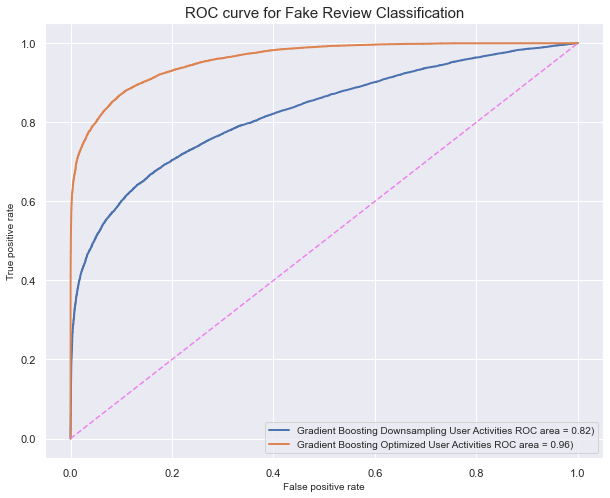

In [81]:
plt.figure(figsize=(10,8))
#GradientBoosting with downsampling user activity
fpr_gb1, tpr_gb1, thresholds = roc_curve(y_test, activity_pipelines[1].predict_proba(X_activity_test)[:,1])
fpr_gb_best, tpr_gb_best, thresholds = roc_curve(y_test, new_gb_model.predict_proba(X_activity_test)[:,1])

roc_auc_GB_activity=roc_auc_score(y_test, activity_pipelines[1].predict_proba(X_activity_test)[:,1])
roc_auc_GB_best=roc_auc_score(y_test, new_gb_model.predict_proba(X_activity_test)[:,1])

#GradientBoosting with downsampling
plt.plot(fpr_gb1, tpr_gb1,lw=2, label='Gradient Boosting Downsampling User Activities ROC area = %0.2f)' 
         % roc_auc_GB_activity)

#GradientBoosting with downsampling
plt.plot(fpr_gb_best, tpr_gb_best, lw=2, label='Gradient Boosting Optimized User Activities ROC area = %0.2f)' 
         % roc_auc_GB_best)


plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.legend(loc="lower right",ncol=1,fontsize = 'small')
plt.xlabel('False positive rate',fontsize=10)
plt.ylabel('True positive rate',fontsize=10)
plt.title('ROC curve for Fake Review Classification',fontsize=15);

### f. Best Model Feature Importance

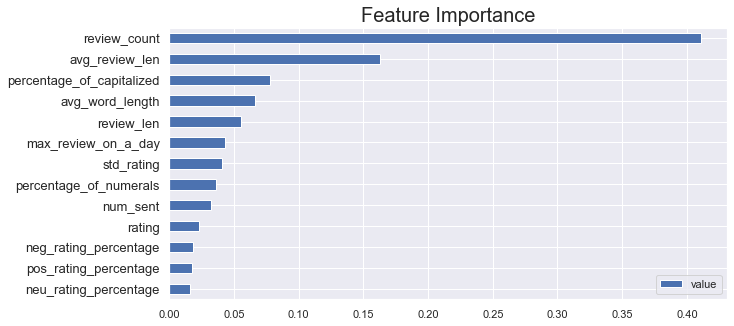

In [82]:
gb_activity_importances=new_gb_model.feature_importances_

indices = np.argsort(gb_activity_importances)
# X_activity_train[indices]

feature_importance=pd.DataFrame(list(zip(list(X_activity_train.columns[indices]),gb_activity_importances)),
             columns=['feature','value'])

feature_importance.sort_values(by='value',ascending=True).plot(kind='barh',sort_columns=True,figsize=(10,5))
plt.title('Feature Importance',fontsize=20)
plt.yticks(feature_importance.index,feature_importance['feature'].values,fontsize=13);

## III. Unsupervised Learning

Outlier Detection with Isolation Forest

### a. Using User Activeties Data

In [116]:
from sklearn.ensemble import IsolationForest

In [113]:
data.head()

,label,review_id,review,rating,max_review_on_a_day,review_count,neg_rating_percentage,pos_rating_percentage,neu_rating_percentage,review_len,avg_review_len,std_rating,avg_word_length,num_sent,percentage_of_numerals,percentage_of_capitalized
0,-1,0,"Drinks were bad, the hot chocolate was watered...",1.0,1,1,1.0,0.00,0.00,187,187.0,0.0,4.22,2,0.00000,0.013605
1,-1,1,This was the worst experience I've ever had a ...,1.0,1,1,1.0,0.00,0.00,1375,1375.0,0.0,4.50,16,0.00565,0.022599
2,-1,2,This is located on the site of the old Spruce ...,3.0,1,4,0.0,0.25,0.75,257,245.5,0.5,4.10,4,0.00000,0.055276
3,-1,3,I am becoming frustrated with yelp. I placed ...,3.0,1,4,0.0,0.25,0.75,352,245.5,0.5,4.63,5,0.00722,0.036101
4,-1,4,The pumpkin pancakes are quite good but the pl...,3.0,1,4,0.0,0.25,0.75,154,245.5,0.5,4.70,2,0.00000,0.024194


In [120]:
X=data.iloc[:,3:]
y = data.iloc[:,:1]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=3)

print(f"Total training records = {len(X_train)}")
print(f"Total testing records = {len(X_test)}")

Total training records = 456293
Total testing records = 152098


In [150]:
# Isolation Forest ----

# training the model
model_final=IsolationForest(n_estimators=50, max_samples='auto', contamination=float(0.1),max_features=1.0)
model_final.fit(X_train)

In [153]:
y_activity_test=y_test.copy()
y_activity_test.loc[:,'scores']=model_final.decision_function(X_test)
y_activity_test.loc[:,'anomaly']=model_final.predict(X_test)

In [138]:
y_activity_test.head(20)

,label,scores,anomaly
240497,1,0.068753,1
387416,-1,0.135379,1
209976,1,-0.004027,1
367408,1,0.056090,1
184220,1,0.036906,1
261480,1,0.096093,1
127394,1,0.035391,1
77691,1,0.055706,1
483689,1,-0.000984,1
244496,1,0.070012,1


In [139]:
#change lable to int64
y_activity_test['label']=[int(x) for x in y_activity_test['label']]

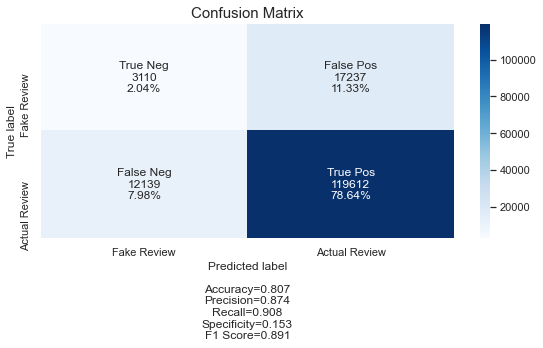

In [140]:
sns.set(font_scale=1.0)
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Fake Review', 'Actual Review']

cm_isolation = confusion_matrix(y_activity_test['label'], y_activity_test['anomaly'])
make_confusion_matrix(cm_isolation, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues',figsize=(8,5))

plt.title('Confusion Matrix',fontsize=15)
plt.tight_layout();

Although the F1 score is pretty high using this isolation forest model, the true negative rate is too low. This means that the model has a hard time capturing frauds. As expected, the specificity score is low.

### b. Using Reviews Word2Vec data

In [143]:
#using data_as_df w2v dataset
# clean_data_as_df

data_as_df=pd.read_csv('clean_data_as_df.csv',index_col=0)
data_as_df.head()

,label,review_id,review,C1,C2,C3,C4,C5,C6,C7,...,C91,C92,C93,C94,C95,C96,C97,C98,C99,C100
0,1,558391,Damn good pizzaria Old fashioned brick oven co...,0.118176,-0.005540,-0.118697,0.004663,0.225756,0.110888,-0.067641,...,0.003960,0.149121,-0.014126,0.003619,0.033720,0.158498,-0.023986,-0.141746,-0.050047,0.161457
1,1,93260,The entrees here are classic hearty dishes thi...,0.097937,0.085351,-0.139262,-0.066124,0.205679,-0.090262,-0.034592,...,-0.228383,0.086872,-0.160074,-0.068987,-0.097264,0.071557,-0.086675,-0.158406,-0.061039,0.245379
2,1,328802,What can I say If you want better Italian food...,0.084738,-0.079039,-0.026011,-0.079858,0.212637,-0.000920,-0.096243,...,-0.075990,0.028098,-0.027545,0.004868,0.000700,0.180517,-0.081295,-0.069636,-0.194717,0.131500
3,1,138491,Stopped by here for lunch and a brew on a warm...,0.063559,0.029708,-0.098327,-0.005688,0.247395,0.020205,-0.037919,...,-0.132956,0.048136,-0.009286,0.043280,0.004087,0.079074,0.002828,-0.163538,-0.046593,0.170076
4,1,555771,We need one of these in every neighborhood Sup...,0.146168,0.091399,-0.118312,-0.042718,0.211164,0.070250,0.001079,...,-0.055113,0.066783,-0.065623,-0.042693,-0.005330,0.123948,0.017047,-0.179111,-0.010585,0.158528


In [145]:
data_as_df.drop(['review_id','review'],axis=1,inplace=True)

In [146]:
X=data_as_df.iloc[:,1:]
y = data_as_df.iloc[:,:1]

In [148]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=3)

print(f"Total training records = {len(X_train)}")
print(f"Total testing records = {len(X_test)}")

Total training records = 120601
Total testing records = 40201


In [151]:
# Isolation Forest ----

# training the model
model=IsolationForest(n_estimators=50, max_samples='auto', contamination=float(0.1),max_features=1.0)
model.fit(X_train)

In [156]:
y_text_test=y_test.copy()
y_text_test.loc[:,'scores']=model.decision_function(X_test)
y_text_test.loc[:,'anomaly']=model.predict(X_test)

In [155]:
y_text_test.head(20)

,label,scores,anomaly
139679,-1,0.050178,1
111141,-1,0.088602,1
20897,1,0.065660,1
75943,1,0.086985,1
62302,1,0.117100,1
49443,1,0.095628,1
78759,1,0.118212,1
155199,-1,-0.039908,-1
149210,-1,0.077020,1
140344,-1,0.127422,1


In [158]:
#change lable to int64
y_text_test['label']=[int(x) for x in y_text_test['label']]

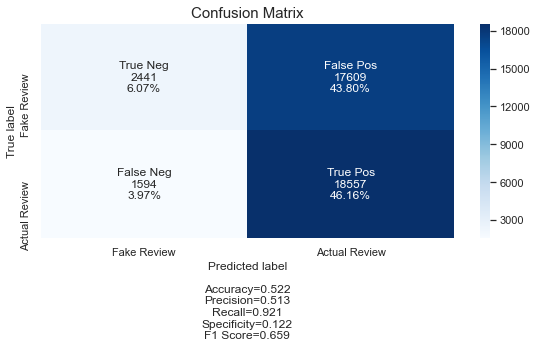

In [159]:
sns.set(font_scale=1.0)
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['Fake Review', 'Actual Review']

cm_isolation_text = confusion_matrix(y_text_test['label'], y_text_test['anomaly'])
make_confusion_matrix(cm_isolation_text, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues',figsize=(8,5))

plt.title('Confusion Matrix',fontsize=15)
plt.tight_layout();

The specificity score is not as well as the previous model using user activities data (more data), but the True negative rate is higher than the previous model.

## Conclusion

After experimenting with different datasets and several methods, we can conclude that using user behavior data is better than using text data when it comes to detecting fake reviews. One possible reason is that A.I. bots are better trained and now can write more human-realistic reviews, which make it even harder to catch fake reviews. Moreover, since it usually takes a long time to convert large amounts of text to vectors, using user activities data is way faster and more robust. In this dataset, we saw that supervised learning gives us better results; however, this result might not apply to other datasets, especially without prelabeled data. While the results might not stay the same, the explained approach in this article works on any unseen domain by using NLP and Machine Learning techniques.